In [1]:
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

2024-07-17 17:50:32.786847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 17:50:32.841345: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 17:50:32.861008: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-17 17:50:32.924510: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-17 17:50:37.398053: W tensorflow/comp

In [2]:
SEED = 17
def set_seed(seed=SEED):
    random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seed(SEED)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

tf.get_logger().setLevel('ERROR')

In [3]:
train = pd.read_csv('inputs/tpm_train.csv', index_col=0)
label_train = pd.read_csv('inputs/label_train.csv')
test = pd.read_csv('inputs/tpm_test.csv', index_col=0)
label_test = pd.read_csv('inputs/label_test.csv')

selected_features = pd.read_csv("inputs/selected_features_tpm_300.csv", header=None).iloc[1:, 0].tolist()
X_selected_test = test[selected_features]
X_selected_train = train[selected_features]

label_test.set_index('sample', inplace=True)
label_train.set_index('sample', inplace=True)

data_test = X_selected_test.join(label_test[['label', 'subject', 'batch']])
data_train = X_selected_train.join(label_train[['label', 'subject', 'batch']])

In [4]:
@tf.keras.utils.register_keras_serializable()
def create_triplets(data):
    triplets = set()
    triplet_features = []
    
    for patient_id in data['subject'].unique():
        primary_samples = data[(data['subject'] == patient_id) & (data['label'] == 0)]
        relapse_samples = data[(data['subject'] == patient_id) & (data['label'] == 1)]
        
        if primary_samples.empty or relapse_samples.empty:
            continue
        
        same_center_primary = data[(data['batch'] == primary_samples['batch'].values[0]) & (data['label'] == 0) & (data['subject'] != patient_id)]
        same_center_relapse = data[(data['batch'] == primary_samples['batch'].values[0]) & (data['label'] == 1) & (data['subject'] != patient_id)]
        
        for _, primary in primary_samples.iterrows():
            for _, relapse in relapse_samples.iterrows():
                for _, same_center_p in same_center_primary.iterrows():
                    anchor_primary = primary[selected_features].values
                    positive_primary = same_center_p[selected_features].values
                    negative_primary = relapse[selected_features].values
                    triplet1 = (anchor_primary, positive_primary, negative_primary)
                    identifier1 = tuple(sorted([primary.name, same_center_p.name, relapse.name]))
                    
                    if identifier1 not in triplets:
                        triplets.add(identifier1)
                        triplet_features.append(triplet1)
                
                for _, same_center_r in same_center_relapse.iterrows():
                    anchor_relapse = relapse[selected_features].values
                    positive_relapse = same_center_r[selected_features].values
                    negative_relapse = primary[selected_features].values
                    triplet2 = (anchor_relapse, positive_relapse, negative_relapse)
                    identifier2 = tuple(sorted([relapse.name, same_center_r.name, primary.name]))
                    
                    if identifier2 not in triplets:
                        triplets.add(identifier2)
                        triplet_features.append(triplet2)
    
    return triplet_features

In [5]:
def stratified_group_kfold_split(data, stratify_col, group_col, n_splits=5, seed=SEED):

    unique_batches = data[stratify_col].unique()

    fold_indices = {i: {"train": [], "val": []} for i in range(n_splits)}

    for batch in unique_batches:
        batch_data = data[data[stratify_col] == batch]
        unique_subjects = batch_data[group_col].unique()

        if len(unique_subjects) <= 2:
            for i in range(n_splits):
                fold_indices[i]["train"].extend(batch_data.index)
        else:

            kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
            for fold, (train_subjects_idx, val_subjects_idx) in enumerate(kf.split(unique_subjects)):
                train_subjects = unique_subjects[train_subjects_idx]
                val_subjects = unique_subjects[val_subjects_idx]
                fold_indices[fold]["train"].extend(batch_data[batch_data[group_col].isin(train_subjects)].index)
                fold_indices[fold]["val"].extend(batch_data[batch_data[group_col].isin(val_subjects)].index)

    return fold_indices


k = 5

fold_indices = stratified_group_kfold_split(data_train, stratify_col='batch', group_col='subject', n_splits=k)

In [6]:
@tf.keras.utils.register_keras_serializable()
def siamese_network(input_shape, units1, units2, units3, dropout, l2_reg, seed=SEED):
    initializer = HeUniform(seed=seed)

    input = layers.Input(shape=input_shape)
    
    x = layers.Dense(units1, kernel_regularizer=regularizers.l2(l2_reg), kernel_initializer=initializer)(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(units2, kernel_regularizer=regularizers.l2(l2_reg), kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(units3, kernel_regularizer=regularizers.l2(l2_reg), kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    output = x
    return Model(input, output)

@tf.keras.utils.register_keras_serializable()
def euclidean_distance_squared(vectors):
    x, y = vectors
    return tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)

@tf.keras.utils.register_keras_serializable()
def soft_triplet_loss(margin):
    def loss(y_true, y_pred):
        positive_distance = y_pred[:, 0]
        negative_distance = y_pred[:, 1]
        return tf.reduce_mean(tf.nn.softplus(positive_distance - negative_distance + margin))
    return loss

In [7]:
input_shape = (len(selected_features),)
input_anchor = layers.Input(shape=input_shape, name='anchor_input')
input_positive = layers.Input(shape=input_shape, name='positive_input')
input_negative = layers.Input(shape=input_shape, name='negative_input')

def create_siamese_model(params):
    base_network = siamese_network(input_shape, params['units1'], params['units2'], params['units3'], params['dropout'], params['l2_reg'])
    
    processed_anchor = base_network(input_anchor)
    processed_positive = base_network(input_positive)
    processed_negative = base_network(input_negative)

    distance_positive = layers.Lambda(euclidean_distance_squared, name='positive_distance')([processed_anchor, processed_positive])
    distance_negative = layers.Lambda(euclidean_distance_squared, name='negative_distance')([processed_anchor, processed_negative])

    output = layers.Concatenate(name='distance')([distance_positive, distance_negative])
    model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=output)

    return model, base_network

In [8]:
import optuna
from optuna.samplers import TPESampler

def objective(trial):
    try:
        params = {
            'margin': trial.suggest_float('margin', 0.1, 1),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
            'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256]),
            'l2_reg': trial.suggest_float('l2_reg', 0.01, 0.5),
            'dropout': trial.suggest_float('dropout', 0.01, 0.5),
            'units1': trial.suggest_int('units1', 32, 512, step=32),
            'units2': trial.suggest_int('units2', 32, 512, step=32),
            'units3': trial.suggest_int('units3', 16, 256, step=16)
        }
        
        accuracies = []
        
        for fold in range(k):
            train_indices = fold_indices[fold]['train']
            val_indices = fold_indices[fold]['val']

            train_data = data_train.loc[train_indices]
            val_data = data_train.loc[val_indices]

            triplet_features_train = create_triplets(train_data)
            triplet_features_val = create_triplets(val_data)

            train_anchors, train_positives, train_negatives = zip(*triplet_features_train)
            train_anchors = np.array(train_anchors, dtype=np.float32)
            train_positives = np.array(train_positives, dtype=np.float32)
            train_negatives = np.array(train_negatives, dtype=np.float32)

            val_anchors, val_positives, val_negatives = zip(*triplet_features_val)
            val_anchors = np.array(val_anchors, dtype=np.float32)
            val_positives = np.array(val_positives, dtype=np.float32)
            val_negatives = np.array(val_negatives, dtype=np.float32)

            set_seed(SEED)
            model, base_network = create_siamese_model(params)
            optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
            model.compile(optimizer=optimizer, loss=soft_triplet_loss(params['margin']))

            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)
            model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=0)

            history = model.fit(
                [train_anchors, train_positives, train_negatives],
                np.zeros(len(train_anchors)),
                validation_data=([val_anchors, val_positives, val_negatives], np.zeros(len(val_anchors))),
                epochs=1000,
                batch_size=params['batch_size'],
                callbacks=[early_stopping, reduce_lr, model_checkpoint],
                verbose=0
            )

            val_loss = np.min(history.history['val_loss'])

            trial.report(val_loss, fold)

            if trial.should_prune() or np.isnan(val_loss):
                raise optuna.exceptions.TrialPruned()

            best_siamese_model = tf.keras.models.load_model('best_model.keras', custom_objects={'soft_triplet_loss': soft_triplet_loss, 'euclidean_distance_squared': euclidean_distance_squared})

            base_network = best_siamese_model.get_layer(best_siamese_model.layers[3].name)

            feature_extractor = Model(inputs=base_network.input, outputs=base_network.output)

            val_anchor_embeddings = feature_extractor.predict(val_anchors, verbose=0)
            val_positive_embeddings = feature_extractor.predict(val_positives, verbose=0)
            val_negative_embeddings = feature_extractor.predict(val_negatives, verbose=0)

            positive_distances = euclidean_distance_squared([val_anchor_embeddings, val_positive_embeddings])
            negative_distances = euclidean_distance_squared([val_anchor_embeddings, val_negative_embeddings])

            y_true = np.ones_like(positive_distances)
            y_pred = positive_distances < negative_distances

            accuracy = accuracy_score(y_true, y_pred)
            accuracies.append(accuracy)

        print(f"All fold accuracies: {accuracies}")
        final_mean = np.mean(accuracies)
        final_std = np.std(accuracies)
        return final_mean - 0.1 * final_std
    
    except optuna.exceptions.TrialPruned:
        raise
    except Exception as e:
        print(f"Error during trial: {e}")
        return -np.inf

In [9]:
best_params = {
    'margin': 0.7892962351946302, 
    'learning_rate': 0.00013872828453666744, 
    'batch_size': 32, 
    'l2_reg': 0.31426583898902993, 
    'dropout': 0.0787996791082391, 
    'units1': 32, 
    'units2': 448, 
    'units3': 176
}

# Best is trial 17 with value: 0.8880687017987572.
# All fold accuracies: [0.8297872340425532, 0.7978723404255319, 0.9308510638297872, 0.9456521739130435, 0.9702380952380952]

In [10]:
sampler = TPESampler(seed=SEED)
pruner = optuna.pruners.MedianPruner()

study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_params = best_trial.params
best_value = best_trial.value
print(f'Best trial:\n  Score: {best_value}\n  Params: {best_params}')

import joblib
joblib.dump(study, 'study.pkl')

[I 2024-07-16 00:00:36,532] A new study created in memory with name: no-name-78475443-f6d6-47d1-9280-9fc1efa6fb60
[I 2024-07-16 00:02:34,371] Trial 0 finished with value: 0.876419716124063 and parameters: {'margin': 0.3651985024183988, 'learning_rate': 0.000390625208786718, 'batch_size': 64, 'l2_reg': 0.29204541793898664, 'dropout': 0.029140828932544577, 'units1': 192, 'units2': 512, 'units3': 16}. Best is trial 0 with value: 0.876419716124063.


All fold accuracies: [0.7978723404255319, 0.8457446808510638, 0.9414893617021277, 0.9184782608695652, 0.9047619047619048]


[I 2024-07-16 00:05:55,579] Trial 1 finished with value: 0.8796132042941569 and parameters: {'margin': 0.8776378931915899, 'learning_rate': 0.004284218166654817, 'batch_size': 32, 'l2_reg': 0.14866419881992568, 'dropout': 0.1558856019678681, 'units1': 288, 'units2': 224, 'units3': 208}. Best is trial 1 with value: 0.8796132042941569.


All fold accuracies: [0.7393617021276596, 0.8351063829787234, 1.0, 0.9347826086956522, 0.9345238095238095]


[I 2024-07-16 00:13:51,243] Trial 2 finished with value: 0.8229473955398803 and parameters: {'margin': 0.4766359468112893, 'learning_rate': 2.7021643645895077e-05, 'batch_size': 64, 'l2_reg': 0.4173683219321553, 'dropout': 0.2883156486650692, 'units1': 64, 'units2': 288, 'units3': 48}. Best is trial 1 with value: 0.8796132042941569.


All fold accuracies: [0.7446808510638298, 0.7872340425531915, 0.8031914893617021, 0.907608695652174, 0.9047619047619048]


[I 2024-07-16 00:29:51,572] Trial 3 finished with value: 0.7850270152224731 and parameters: {'margin': 0.7090861471326644, 'learning_rate': 2.2668187415675055e-05, 'batch_size': 256, 'l2_reg': 0.33301064226425064, 'dropout': 0.36220028077997296, 'units1': 384, 'units2': 480, 'units3': 48}. Best is trial 1 with value: 0.8796132042941569.


All fold accuracies: [0.6808510638297872, 0.7287234042553191, 0.8031914893617021, 0.8369565217391305, 0.9166666666666666]


[I 2024-07-16 00:34:24,291] Trial 4 finished with value: 0.8677934704867193 and parameters: {'margin': 0.7992771225450221, 'learning_rate': 0.003265686843412085, 'batch_size': 16, 'l2_reg': 0.25150761034118524, 'dropout': 0.07391034828222333, 'units1': 512, 'units2': 64, 'units3': 160}. Best is trial 1 with value: 0.8796132042941569.


All fold accuracies: [0.7393617021276596, 0.8191489361702128, 0.9787234042553191, 0.9402173913043478, 0.9047619047619048]


[I 2024-07-16 00:36:53,807] Trial 5 finished with value: 0.8241880243709744 and parameters: {'margin': 0.6226973425780552, 'learning_rate': 0.007294803480968199, 'batch_size': 64, 'l2_reg': 0.386413315319873, 'dropout': 0.43730145511705354, 'units1': 480, 'units2': 160, 'units3': 64}. Best is trial 1 with value: 0.8796132042941569.


All fold accuracies: [0.6914893617021277, 0.7180851063829787, 0.9042553191489362, 0.9565217391304348, 0.9047619047619048]


[I 2024-07-16 00:37:10,466] Trial 6 pruned. 
[I 2024-07-16 00:37:38,369] Trial 7 pruned. 
[I 2024-07-16 00:38:06,862] Trial 8 pruned. 
[I 2024-07-16 00:39:21,791] Trial 9 finished with value: 0.8419967166208161 and parameters: {'margin': 0.5040550614673256, 'learning_rate': 0.004918830132018964, 'batch_size': 256, 'l2_reg': 0.07370735640613965, 'dropout': 0.33394521002777466, 'units1': 96, 'units2': 160, 'units3': 256}. Best is trial 1 with value: 0.8796132042941569.


All fold accuracies: [0.7606382978723404, 0.7659574468085106, 1.0, 0.907608695652174, 0.8214285714285714]


[I 2024-07-16 00:45:10,758] Trial 10 finished with value: 0.7976511129895294 and parameters: {'margin': 0.1654000230151788, 'learning_rate': 0.00010166610482027034, 'batch_size': 32, 'l2_reg': 0.01728304635002373, 'dropout': 0.18905120954330207, 'units1': 288, 'units2': 288, 'units3': 256}. Best is trial 1 with value: 0.8796132042941569.


All fold accuracies: [0.7127659574468085, 0.6702127659574468, 0.7978723404255319, 0.9510869565217391, 0.9107142857142857]


[I 2024-07-16 00:47:44,514] Trial 11 finished with value: 0.8641598820942822 and parameters: {'margin': 0.9702106050451286, 'learning_rate': 0.0004211529598944795, 'batch_size': 32, 'l2_reg': 0.16089763942074298, 'dropout': 0.018846694082527107, 'units1': 256, 'units2': 512, 'units3': 192}. Best is trial 1 with value: 0.8796132042941569.


All fold accuracies: [0.8085106382978723, 0.7872340425531915, 0.9521276595744681, 0.9239130434782609, 0.8809523809523809]


[I 2024-07-16 00:51:18,811] Trial 12 finished with value: 0.8660425985339072 and parameters: {'margin': 0.27248875451905535, 'learning_rate': 0.00023999807779752073, 'batch_size': 16, 'l2_reg': 0.18781629413274117, 'dropout': 0.17746833146336574, 'units1': 256, 'units2': 384, 'units3': 96}. Best is trial 1 with value: 0.8796132042941569.


All fold accuracies: [0.7606382978723404, 0.824468085106383, 0.9840425531914894, 0.9184782608695652, 0.8809523809523809]


[I 2024-07-16 00:51:37,240] Trial 13 pruned. 
[I 2024-07-16 00:56:42,848] Trial 14 finished with value: 0.7894500788757174 and parameters: {'margin': 0.12781275268805886, 'learning_rate': 6.0934071935016845e-05, 'batch_size': 64, 'l2_reg': 0.11639379213953208, 'dropout': 0.18561584814353171, 'units1': 352, 'units2': 192, 'units3': 96}. Best is trial 1 with value: 0.8796132042941569.


All fold accuracies: [0.7021276595744681, 0.6542553191489362, 0.8776595744680851, 0.8369565217391305, 0.9285714285714286]


[I 2024-07-16 00:57:16,158] Trial 15 pruned. 
[I 2024-07-16 01:11:25,895] Trial 16 finished with value: 0.7901713109053238 and parameters: {'margin': 0.9830403427641876, 'learning_rate': 1.1442275257635478e-05, 'batch_size': 64, 'l2_reg': 0.2290208981575862, 'dropout': 0.23320559866697638, 'units1': 192, 'units2': 320, 'units3': 112}. Best is trial 1 with value: 0.8796132042941569.


All fold accuracies: [0.7287234042553191, 0.7127659574468085, 0.7978723404255319, 0.842391304347826, 0.9047619047619048]


[I 2024-07-16 01:14:18,364] Trial 17 finished with value: 0.8880687017987572 and parameters: {'margin': 0.7892962351946302, 'learning_rate': 0.00013872828453666744, 'batch_size': 32, 'l2_reg': 0.31426583898902993, 'dropout': 0.0787996791082391, 'units1': 32, 'units2': 448, 'units3': 176}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.8297872340425532, 0.7978723404255319, 0.9308510638297872, 0.9456521739130435, 0.9702380952380952]


[I 2024-07-16 01:18:31,670] Trial 18 finished with value: 0.7978756275344699 and parameters: {'margin': 0.8288629916572335, 'learning_rate': 0.00010731199513482482, 'batch_size': 32, 'l2_reg': 0.11068265258629145, 'dropout': 0.11647710931297872, 'units1': 384, 'units2': 352, 'units3': 192}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.6702127659574468, 0.6702127659574468, 0.9148936170212766, 0.8804347826086957, 0.9107142857142857]


[I 2024-07-16 01:19:01,676] Trial 19 pruned. 
[I 2024-07-16 01:19:20,992] Trial 20 pruned. 
[I 2024-07-16 01:22:43,454] Trial 21 finished with value: 0.853550592995106 and parameters: {'margin': 0.6123289629096291, 'learning_rate': 0.0001419746322534015, 'batch_size': 32, 'l2_reg': 0.30455460110348614, 'dropout': 0.05757670284764524, 'units1': 224, 'units2': 512, 'units3': 224}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.723404255319149, 0.8351063829787234, 0.9627659574468085, 0.9510869565217391, 0.8392857142857143]


[I 2024-07-16 01:29:52,160] Trial 22 finished with value: 0.8112295999889616 and parameters: {'margin': 0.9134771210561372, 'learning_rate': 5.0158004991049786e-05, 'batch_size': 128, 'l2_reg': 0.35650958840886976, 'dropout': 0.15198928679705426, 'units1': 32, 'units2': 448, 'units3': 144}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.7872340425531915, 0.6968085106382979, 0.8031914893617021, 0.8586956521739131, 0.9523809523809523]


[I 2024-07-16 01:30:11,506] Trial 23 pruned. 
[I 2024-07-16 01:30:47,830] Trial 24 pruned. 
[I 2024-07-16 01:31:02,370] Trial 25 pruned. 
[I 2024-07-16 01:31:30,428] Trial 26 pruned. 
[I 2024-07-16 01:36:58,346] Trial 27 finished with value: 0.8065690037243617 and parameters: {'margin': 0.7111854383404342, 'learning_rate': 5.788169846736108e-05, 'batch_size': 32, 'l2_reg': 0.06898550914465143, 'dropout': 0.21229963466889248, 'units1': 288, 'units2': 352, 'units3': 80}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.7127659574468085, 0.6542553191489362, 0.9308510638297872, 0.8804347826086957, 0.9107142857142857]


[I 2024-07-16 01:39:01,646] Trial 28 finished with value: 0.8713062561978415 and parameters: {'margin': 0.9446305106802568, 'learning_rate': 0.0003854706544561908, 'batch_size': 64, 'l2_reg': 0.32316188159124243, 'dropout': 0.14270543985142065, 'units1': 160, 'units2': 480, 'units3': 240}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.7180851063829787, 0.851063829787234, 0.9042553191489362, 0.9891304347826086, 0.9404761904761905]


[I 2024-07-16 01:40:22,480] Trial 29 pruned. 
[I 2024-07-16 01:40:41,449] Trial 30 pruned. 
[I 2024-07-16 01:43:23,736] Trial 31 finished with value: 0.8245167615425661 and parameters: {'margin': 0.9231257846830506, 'learning_rate': 0.00016216048946694907, 'batch_size': 64, 'l2_reg': 0.32166755351146376, 'dropout': 0.2856582757756888, 'units1': 160, 'units2': 480, 'units3': 240}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.7446808510638298, 0.7872340425531915, 0.8617021276595744, 0.8369565217391305, 0.9226190476190477]


[I 2024-07-16 01:45:33,944] Trial 32 finished with value: 0.8549269202630175 and parameters: {'margin': 0.9424731685481376, 'learning_rate': 0.0003720010547086227, 'batch_size': 64, 'l2_reg': 0.26635549904999545, 'dropout': 0.13268382662029815, 'units1': 192, 'units2': 480, 'units3': 240}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.776595744680851, 0.7127659574468085, 0.9574468085106383, 0.9619565217391305, 0.9166666666666666]


[I 2024-07-16 01:49:36,730] Trial 33 finished with value: 0.8263453488263226 and parameters: {'margin': 0.8316724530300891, 'learning_rate': 9.183427441985e-05, 'batch_size': 64, 'l2_reg': 0.39373038487098233, 'dropout': 0.1595847055296447, 'units1': 224, 'units2': 480, 'units3': 208}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.7446808510638298, 0.7127659574468085, 0.8776595744680851, 0.9184782608695652, 0.9226190476190477]


[I 2024-07-16 01:49:57,354] Trial 34 pruned. 
[I 2024-07-16 01:53:11,369] Trial 35 finished with value: 0.8697796985885469 and parameters: {'margin': 0.9957759465928935, 'learning_rate': 0.00027750849991350424, 'batch_size': 16, 'l2_reg': 0.2500822410885252, 'dropout': 0.2193348715799064, 'units1': 96, 'units2': 512, 'units3': 176}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.7446808510638298, 0.8031914893617021, 0.973404255319149, 0.9619565217391305, 0.9107142857142857]


[I 2024-07-16 02:02:58,668] Trial 36 finished with value: 0.7277915536719056 and parameters: {'margin': 0.8876222327909402, 'learning_rate': 1.7075119051901663e-05, 'batch_size': 64, 'l2_reg': 0.30852095122565537, 'dropout': 0.1079065480188188, 'units1': 128, 'units2': 256, 'units3': 240}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.7021276595744681, 0.6968085106382979, 0.7021276595744681, 0.75, 0.8095238095238095]


[I 2024-07-16 02:03:21,124] Trial 37 pruned. 
[I 2024-07-16 02:03:44,488] Trial 38 pruned. 
[I 2024-07-16 02:04:01,566] Trial 39 pruned. 
[I 2024-07-16 02:06:42,330] Trial 40 pruned. 
[I 2024-07-16 02:07:10,373] Trial 41 pruned. 
[I 2024-07-16 02:08:20,634] Trial 42 pruned. 
[I 2024-07-16 02:09:03,910] Trial 43 pruned. 
[I 2024-07-16 02:10:27,743] Trial 44 pruned. 
[I 2024-07-16 02:11:01,622] Trial 45 pruned. 
[I 2024-07-16 02:13:53,895] Trial 46 finished with value: 0.8834585171754363 and parameters: {'margin': 0.4205940732148079, 'learning_rate': 0.0002862900038050515, 'batch_size': 32, 'l2_reg': 0.2758579577897391, 'dropout': 0.21185604975604766, 'units1': 192, 'units2': 416, 'units3': 224}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.7180851063829787, 0.8882978723404256, 0.9574468085106383, 0.9347826086956522, 0.9642857142857143]


[I 2024-07-16 02:14:12,024] Trial 47 pruned. 
[I 2024-07-16 02:18:00,703] Trial 48 finished with value: 0.832117016681495 and parameters: {'margin': 0.3472917355541487, 'learning_rate': 8.289186356901329e-05, 'batch_size': 32, 'l2_reg': 0.20058508479834486, 'dropout': 0.1738185089801593, 'units1': 192, 'units2': 352, 'units3': 240}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.7606382978723404, 0.776595744680851, 0.8617021276595744, 0.8804347826086957, 0.9107142857142857]


[I 2024-07-16 02:18:31,319] Trial 49 pruned. 
[I 2024-07-16 02:19:16,625] Trial 50 pruned. 
[I 2024-07-16 02:21:58,399] Trial 51 finished with value: 0.8628589439219128 and parameters: {'margin': 0.41433230374903995, 'learning_rate': 0.0002655983648135453, 'batch_size': 32, 'l2_reg': 0.2455390005002599, 'dropout': 0.2217326851560296, 'units1': 128, 'units2': 480, 'units3': 224}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.7819148936170213, 0.8031914893617021, 0.925531914893617, 0.9184782608695652, 0.9166666666666666]


[I 2024-07-16 02:22:20,267] Trial 52 pruned. 
[I 2024-07-16 02:26:11,386] Trial 53 finished with value: 0.8302211821130177 and parameters: {'margin': 0.8113823605748475, 'learning_rate': 0.00011531395719992304, 'batch_size': 32, 'l2_reg': 0.05178335792529176, 'dropout': 0.2035290793770292, 'units1': 96, 'units2': 256, 'units3': 208}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.723404255319149, 0.7659574468085106, 0.898936170212766, 0.8967391304347826, 0.9047619047619048]


[I 2024-07-16 02:26:34,882] Trial 54 pruned. 
[I 2024-07-16 02:27:14,322] Trial 55 pruned. 
[I 2024-07-16 02:27:39,172] Trial 56 pruned. 
[I 2024-07-16 02:31:50,387] Trial 57 finished with value: 0.6963879863668555 and parameters: {'margin': 0.4640551568450708, 'learning_rate': 0.00012388936417057935, 'batch_size': 256, 'l2_reg': 0.1257758116422796, 'dropout': 0.06966799040003967, 'units1': 352, 'units2': 192, 'units3': 240}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.7446808510638298, 0.5904255319148937, 0.6382978723404256, 0.6684782608695652, 0.8928571428571429]


[I 2024-07-16 02:32:07,269] Trial 58 pruned. 
[I 2024-07-16 02:32:30,475] Trial 59 pruned. 
[I 2024-07-16 02:32:47,306] Trial 60 pruned. 
[I 2024-07-16 02:33:26,823] Trial 61 pruned. 
[I 2024-07-16 02:34:06,567] Trial 62 pruned. 
[I 2024-07-16 02:35:03,052] Trial 63 pruned. 
[I 2024-07-16 02:35:45,825] Trial 64 pruned. 
[I 2024-07-16 02:37:51,671] Trial 65 finished with value: 0.7953838924228928 and parameters: {'margin': 0.4407287030742485, 'learning_rate': 0.00035909546256009177, 'batch_size': 64, 'l2_reg': 0.35997231713367484, 'dropout': 0.03243778502930508, 'units1': 480, 'units2': 320, 'units3': 192}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.6170212765957447, 0.7553191489361702, 0.8936170212765957, 0.967391304347826, 0.8035714285714286]


[I 2024-07-16 02:38:11,571] Trial 66 pruned. 
[I 2024-07-16 02:38:42,863] Trial 67 pruned. 
[I 2024-07-16 02:39:27,878] Trial 68 pruned. 
[I 2024-07-16 02:40:01,909] Trial 69 pruned. 
[I 2024-07-16 02:40:36,199] Trial 70 pruned. 
[I 2024-07-16 02:41:13,123] Trial 71 pruned. 
[I 2024-07-16 02:41:52,994] Trial 72 pruned. 
[I 2024-07-16 02:42:31,819] Trial 73 pruned. 
[I 2024-07-16 02:43:04,605] Trial 74 pruned. 
[I 2024-07-16 02:43:52,816] Trial 75 pruned. 
[I 2024-07-16 02:46:53,642] Trial 76 finished with value: 0.8879388430454092 and parameters: {'margin': 0.3753613164572148, 'learning_rate': 0.00018039738346927877, 'batch_size': 32, 'l2_reg': 0.27011872675535936, 'dropout': 0.07496236851621421, 'units1': 224, 'units2': 480, 'units3': 256}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.8085106382978723, 0.8351063829787234, 0.9946808510638298, 0.9239130434782609, 0.9107142857142857]


[I 2024-07-16 02:50:29,955] Trial 77 finished with value: 0.8287573323014883 and parameters: {'margin': 0.3820536522499305, 'learning_rate': 9.785113372269146e-05, 'batch_size': 32, 'l2_reg': 0.31656963510660324, 'dropout': 0.07378395274387592, 'units1': 224, 'units2': 512, 'units3': 256}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.75, 0.7127659574468085, 0.9414893617021277, 0.9619565217391305, 0.8273809523809523]


[I 2024-07-16 02:54:21,894] Trial 78 finished with value: 0.8495366984773931 and parameters: {'margin': 0.8303748753882851, 'learning_rate': 7.170808255533985e-05, 'batch_size': 32, 'l2_reg': 0.2724467056846145, 'dropout': 0.04774948363471768, 'units1': 192, 'units2': 480, 'units3': 240}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.7712765957446809, 0.7872340425531915, 0.8829787234042553, 0.9402173913043478, 0.8988095238095238]


[I 2024-07-16 02:56:44,717] Trial 79 finished with value: 0.8357346703346066 and parameters: {'margin': 0.3778795565201341, 'learning_rate': 0.00018630426437079079, 'batch_size': 32, 'l2_reg': 0.2835740081569725, 'dropout': 0.02953693237687638, 'units1': 128, 'units2': 480, 'units3': 240}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.6968085106382979, 0.7925531914893617, 0.9095744680851063, 0.9184782608695652, 0.9047619047619048]


[I 2024-07-16 02:59:20,065] Trial 80 finished with value: 0.8304540309371017 and parameters: {'margin': 0.9406388930722087, 'learning_rate': 0.00015991221186287724, 'batch_size': 32, 'l2_reg': 0.3290441104642823, 'dropout': 0.09024011787898664, 'units1': 160, 'units2': 448, 'units3': 256}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.7021276595744681, 0.8191489361702128, 0.8404255319148937, 0.9130434782608695, 0.9166666666666666]


[I 2024-07-16 02:59:46,296] Trial 81 pruned. 
[I 2024-07-16 03:04:51,378] Trial 82 finished with value: 0.8046359292488672 and parameters: {'margin': 0.24249878902990105, 'learning_rate': 4.927633623185828e-05, 'batch_size': 32, 'l2_reg': 0.18241667625659658, 'dropout': 0.023245074030311237, 'units1': 288, 'units2': 416, 'units3': 176}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.6542553191489362, 0.7659574468085106, 0.8457446808510638, 0.9239130434782609, 0.8809523809523809]


[I 2024-07-16 03:05:16,129] Trial 83 pruned. 
[I 2024-07-16 03:05:50,410] Trial 84 pruned. 
[I 2024-07-16 03:06:27,586] Trial 85 pruned. 
[I 2024-07-16 03:08:38,024] Trial 86 finished with value: 0.8041204464919253 and parameters: {'margin': 0.3995071220889828, 'learning_rate': 0.00035874563495085036, 'batch_size': 64, 'l2_reg': 0.31030310950076784, 'dropout': 0.0650276498926417, 'units1': 256, 'units2': 416, 'units3': 256}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.6808510638297872, 0.6382978723404256, 0.925531914893617, 0.9239130434782609, 0.9166666666666666]


[I 2024-07-16 03:09:02,365] Trial 87 pruned. 
[I 2024-07-16 03:11:05,481] Trial 88 finished with value: 0.83087788486378 and parameters: {'margin': 0.7791555408575911, 'learning_rate': 0.0006549642632374546, 'batch_size': 256, 'l2_reg': 0.09925251076251296, 'dropout': 0.13854498821254962, 'units1': 224, 'units2': 448, 'units3': 192}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.7287234042553191, 0.7180851063829787, 0.9414893617021277, 0.8586956521739131, 0.9583333333333334]


[I 2024-07-16 03:11:54,431] Trial 89 pruned. 
[I 2024-07-16 03:16:26,110] Trial 90 finished with value: 0.8441824904276567 and parameters: {'margin': 0.983479762859995, 'learning_rate': 0.00010542976063469547, 'batch_size': 32, 'l2_reg': 0.22097119324875872, 'dropout': 0.19971783783224362, 'units1': 480, 'units2': 512, 'units3': 224}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.7446808510638298, 0.776595744680851, 0.898936170212766, 0.9402173913043478, 0.8988095238095238]


[I 2024-07-16 03:16:50,083] Trial 91 pruned. 
[I 2024-07-16 03:17:13,851] Trial 92 pruned. 
[I 2024-07-16 03:20:09,888] Trial 93 finished with value: 0.8433476709717131 and parameters: {'margin': 0.9337685862530654, 'learning_rate': 0.00018128205860513466, 'batch_size': 32, 'l2_reg': 0.11541049582796034, 'dropout': 0.18480268237842026, 'units1': 192, 'units2': 512, 'units3': 208}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.7287234042553191, 0.8031914893617021, 0.898936170212766, 0.9239130434782609, 0.8988095238095238]


[I 2024-07-16 03:20:33,831] Trial 94 pruned. 
[I 2024-07-16 03:23:15,890] Trial 95 finished with value: 0.8589222954168735 and parameters: {'margin': 0.9941964593002027, 'learning_rate': 0.0002197981824837401, 'batch_size': 32, 'l2_reg': 0.27796338779359514, 'dropout': 0.2274623139946778, 'units1': 128, 'units2': 448, 'units3': 192}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.7340425531914894, 0.776595744680851, 0.973404255319149, 0.9293478260869565, 0.9285714285714286]


[I 2024-07-16 03:23:39,334] Trial 96 pruned. 
[I 2024-07-16 03:24:09,848] Trial 97 pruned. 
[I 2024-07-16 03:38:08,263] Trial 98 finished with value: 0.7366820610189898 and parameters: {'margin': 0.9760554813893776, 'learning_rate': 1.0556585856814425e-05, 'batch_size': 32, 'l2_reg': 0.290188235596638, 'dropout': 0.1622078430910896, 'units1': 96, 'units2': 480, 'units3': 224}. Best is trial 17 with value: 0.8880687017987572.


All fold accuracies: [0.6170212765957447, 0.648936170212766, 0.7659574468085106, 0.7989130434782609, 0.9047619047619048]


[I 2024-07-16 03:38:26,212] Trial 99 pruned. 


Best trial:
  Score: 0.8880687017987572
  Params: {'margin': 0.7892962351946302, 'learning_rate': 0.00013872828453666744, 'batch_size': 32, 'l2_reg': 0.31426583898902993, 'dropout': 0.0787996791082391, 'units1': 32, 'units2': 448, 'units3': 176}


['study.pkl']

In [10]:
for fold in range(k):
    train_indices = fold_indices[fold]['train']
    val_indices = fold_indices[fold]['val']
    train_data = data_train.loc[train_indices]
    val_data = data_train.loc[val_indices]
    print(f"Fold {fold+1} - Train Data Shape: {train_data.shape}, Validation Data Shape: {val_data.shape}")
    # train_data.to_csv(f'train_fold_{fold+1}.csv', index=False)
    # val_data.to_csv(f'val_fold_{fold+1}.csv', index=False)

def print_batch_distribution(data, name):
    batch_distribution = data['batch'].value_counts().sort_index()
    print(f"\n{name} Data Batch Distribution:")
    print(batch_distribution)
    print(f"Total samples in {name} Data: {len(data)}\n")

print_batch_distribution(train_data, "Training")
print_batch_distribution(val_data, "Validation")
print_batch_distribution(data_test, "Test")

Fold 1 - Train Data Shape: (126, 484), Validation Data Shape: (32, 484)
Fold 2 - Train Data Shape: (126, 484), Validation Data Shape: (32, 484)
Fold 3 - Train Data Shape: (126, 484), Validation Data Shape: (32, 484)
Fold 4 - Train Data Shape: (128, 484), Validation Data Shape: (30, 484)
Fold 5 - Train Data Shape: (130, 484), Validation Data Shape: (28, 484)

Training Data Batch Distribution:
batch
DFKZ       14
EORTC      72
Rabadan     4
Stead      40
Name: count, dtype: int64
Total samples in Training Data: 130


Validation Data Batch Distribution:
batch
DFKZ      2
EORTC    18
Stead     8
Name: count, dtype: int64
Total samples in Validation Data: 28


Test Data Batch Distribution:
batch
DFKZ        6
EORTC      26
Rabadan     2
Stead      16
Name: count, dtype: int64
Total samples in Test Data: 50



In [11]:
triplet_features_train = create_triplets(train_data)
triplet_features_val = create_triplets(val_data)
triplet_features_test = create_triplets(data_test)

print("Training Triplets:", len(triplet_features_train))
print("Validation Triplets:", len(triplet_features_val))
print("Test Triplets:", len(triplet_features_test))

Training Triplets: 3368
Validation Triplets: 168
Test Triplets: 436


In [12]:
train_anchors, train_positives, train_negatives = zip(*triplet_features_train)
train_anchors = np.array(train_anchors, dtype=np.float32)
train_positives = np.array(train_positives, dtype=np.float32)
train_negatives = np.array(train_negatives, dtype=np.float32)

val_anchors, val_positives, val_negatives = zip(*triplet_features_val)
val_anchors = np.array(val_anchors, dtype=np.float32)
val_positives = np.array(val_positives, dtype=np.float32)
val_negatives = np.array(val_negatives, dtype=np.float32)

test_anchors, test_positives, test_negatives = zip(*triplet_features_test)
test_anchors = np.array(test_anchors, dtype=np.float32)
test_positives = np.array(test_positives, dtype=np.float32)
test_negatives = np.array(test_negatives, dtype=np.float32)

In [13]:
set_seed(SEED)
model, base_network = create_siamese_model(best_params)
optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
model.compile(optimizer=optimizer, loss=soft_triplet_loss(best_params['margin']))

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-8, verbose=1)
model_checkpoint = ModelCheckpoint('best_siamese_model.keras', monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)

history = model.fit(
    [train_anchors, train_positives, train_negatives],
    np.zeros(len(train_anchors)),
    validation_data=([val_anchors, val_positives, val_negatives], np.zeros(len(val_anchors))),
    epochs=1000,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/1000
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 417.8481
Epoch 1: val_loss improved from inf to 385.98550, saving model to best_siamese_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 417.6323 - val_loss: 385.9855 - learning_rate: 1.3873e-04
Epoch 2/1000
101/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 375.3129
Epoch 2: val_loss improved from 385.98550 to 352.40192, saving model to best_siamese_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 374.8063 - val_loss: 352.4019 - learning_rate: 1.3873e-04
Epoch 3/1000
 98/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 340.6024
Epoch 3: val_loss improved from 352.40192 to 319.65747, saving model to best_siamese_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 339.9015 - val_loss: 319.6575 - learning_rate: 1.3873e-04
Epoch 4/1000
101/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 307.9584
Epoch 4: val_loss improved from 319.65747 to 288.84900, saving model to best_siamese_model.keras
106/106 ━━━

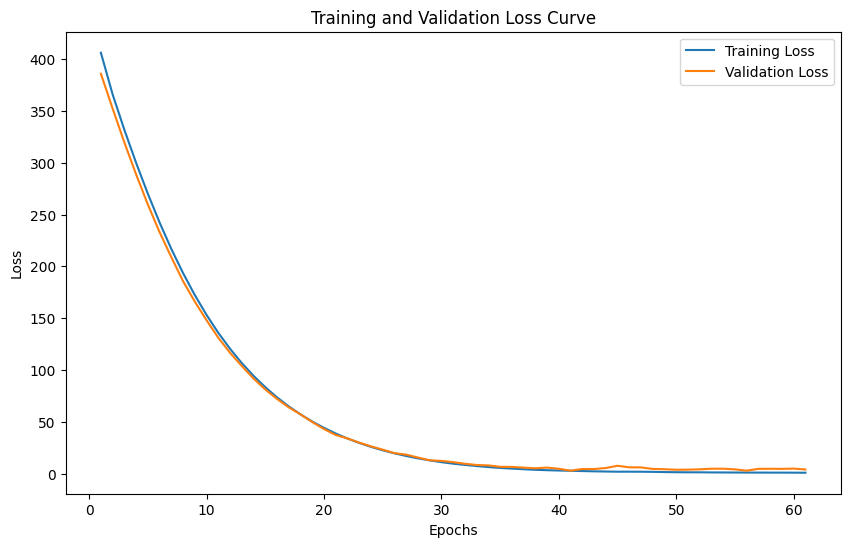

In [14]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

In [15]:
best_siamese_model = tf.keras.models.load_model('best_siamese_model.keras', custom_objects={'soft_triplet_loss': soft_triplet_loss, 'euclidean_distance_squared': euclidean_distance_squared})

base_network = best_siamese_model.get_layer(best_siamese_model.layers[3].name)

feature_extractor = Model(inputs=base_network.input, outputs=base_network.output)

In [16]:
val_anchor_embeddings = feature_extractor.predict(val_anchors, verbose=0)
val_positive_embeddings = feature_extractor.predict(val_positives, verbose=0)
val_negative_embeddings = feature_extractor.predict(val_negatives, verbose=0)

positive_distances = euclidean_distance_squared([val_anchor_embeddings, val_positive_embeddings])
negative_distances = euclidean_distance_squared([val_anchor_embeddings, val_negative_embeddings])

y_true = np.ones_like(positive_distances)
y_pred = positive_distances < negative_distances

accuracy = accuracy_score(y_true, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

Validation Accuracy: 0.9702


In [17]:
test_anchor_embeddings = feature_extractor.predict(test_anchors, verbose=0)
test_positive_embeddings = feature_extractor.predict(test_positives, verbose=0)
test_negative_embeddings = feature_extractor.predict(test_negatives, verbose=0)

positive_distances = euclidean_distance_squared([test_anchor_embeddings, test_positive_embeddings])
negative_distances = euclidean_distance_squared([test_anchor_embeddings, test_negative_embeddings])

y_true = np.ones_like(positive_distances)
y_pred = positive_distances < negative_distances

accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.6537


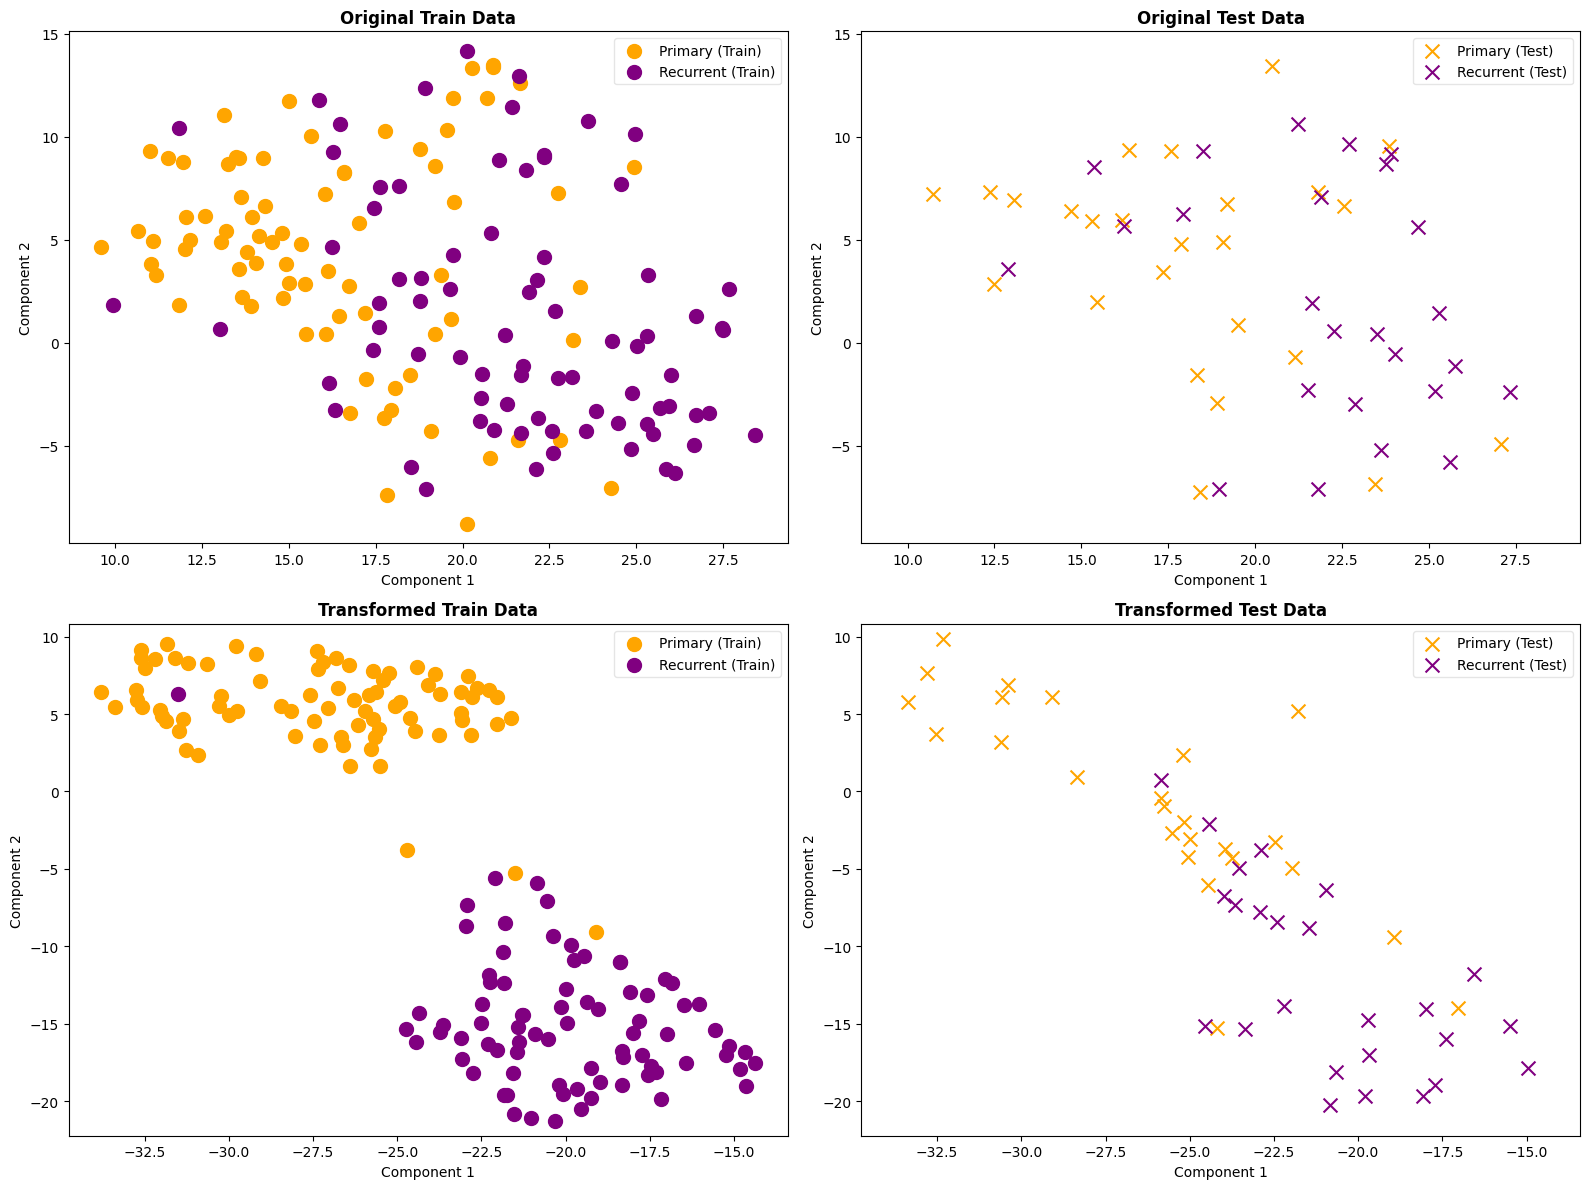

In [18]:
train_features_original = data_train[selected_features].values
test_features_original = data_test[selected_features].values

train_features_transformed = feature_extractor.predict(data_train[selected_features], verbose=0)
test_features_transformed = feature_extractor.predict(data_test[selected_features], verbose=0)

def pad_with_zeros(data, target_shape):
    padded_data = np.zeros(target_shape)
    padded_data[:, :data.shape[1]] = data
    return padded_data

target_shape_train = (train_features_original.shape[0], max(train_features_original.shape[1], train_features_transformed.shape[1]))
target_shape_test = (test_features_original.shape[0], max(test_features_original.shape[1], test_features_transformed.shape[1]))

train_features_transformed_padded = pad_with_zeros(train_features_transformed, target_shape_train)
test_features_transformed_padded = pad_with_zeros(test_features_transformed, target_shape_test)

combined_features = np.concatenate([train_features_original, test_features_original, train_features_transformed_padded, test_features_transformed_padded], axis=0)
tsne = TSNE(n_components=2, random_state=SEED)
combined_features_2d = tsne.fit_transform(combined_features)

train_features_original_2d = combined_features_2d[:len(train_features_original)]
test_features_original_2d = combined_features_2d[len(train_features_original):len(train_features_original) + len(test_features_original)]
train_features_transformed_2d = combined_features_2d[len(train_features_original) + len(test_features_original):len(train_features_original) + len(test_features_original) + len(train_features_transformed_padded)]
test_features_transformed_2d = combined_features_2d[len(train_features_original) + len(test_features_original) + len(train_features_transformed_padded):]

df_train_original = pd.DataFrame(train_features_original_2d, columns=['Component 1', 'Component 2'])
df_train_original['GBM'] = data_train['label'].values

df_test_original = pd.DataFrame(test_features_original_2d, columns=['Component 1', 'Component 2'])
df_test_original['GBM'] = data_test['label'].values

df_train_transformed = pd.DataFrame(train_features_transformed_2d, columns=['Component 1', 'Component 2'])
df_train_transformed['GBM'] = data_train['label'].values

df_test_transformed = pd.DataFrame(test_features_transformed_2d, columns=['Component 1', 'Component 2'])
df_test_transformed['GBM'] = data_test['label'].values

palette = {0: "orange", 1: "purple"}
markers_train = {0: "o", 1: "o"}
markers_test = {0: "x", 1: "x"}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

all_data_original_2d = np.concatenate([train_features_original_2d, test_features_original_2d])
x_min_original, x_max_original = all_data_original_2d[:, 0].min(), all_data_original_2d[:, 0].max()
y_min_original, y_max_original = all_data_original_2d[:, 1].min(), all_data_original_2d[:, 1].max()
margin_original = 0.05 * (x_max_original - x_min_original)

all_data_transformed_2d = np.concatenate([train_features_transformed_2d, test_features_transformed_2d])
x_min_transformed, x_max_transformed = all_data_transformed_2d[:, 0].min(), all_data_transformed_2d[:, 0].max()
y_min_transformed, y_max_transformed = all_data_transformed_2d[:, 1].min(), all_data_transformed_2d[:, 1].max()
margin_transformed = 0.05 * (x_max_transformed - x_min_transformed)

for label, color in palette.items():
    subset = df_train_original[df_train_original['GBM'] == label]
    axes[0, 0].scatter(subset['Component 1'], subset['Component 2'], c=color, label=f'Primary (Train)' if label == 0 else 'Recurrent (Train)', marker=markers_train[label], s=100)
axes[0, 0].set_title('Original Train Data', weight='bold')
axes[0, 0].legend(loc='upper right', frameon=True, framealpha=0.5)
axes[0, 0].set_xlabel('Component 1')
axes[0, 0].set_ylabel('Component 2')
axes[0, 0].set_xlim(x_min_original - margin_original, x_max_original + margin_original)
axes[0, 0].set_ylim(y_min_original - margin_original, y_max_original + margin_original)

for label, color in palette.items():
    subset = df_test_original[df_test_original['GBM'] == label]
    axes[0, 1].scatter(subset['Component 1'], subset['Component 2'], c=color, label=f'Primary (Test)' if label == 0 else 'Recurrent (Test)', marker=markers_test[label], s=100)
axes[0, 1].set_title('Original Test Data', weight='bold')
axes[0, 1].legend(loc='upper right', frameon=True, framealpha=0.5)
axes[0, 1].set_xlabel('Component 1')
axes[0, 1].set_ylabel('Component 2')
axes[0, 1].set_xlim(x_min_original - margin_original, x_max_original + margin_original)
axes[0, 1].set_ylim(y_min_original - margin_original, y_max_original + margin_original)

for label, color in palette.items():
    subset = df_train_transformed[df_train_transformed['GBM'] == label]
    axes[1, 0].scatter(subset['Component 1'], subset['Component 2'], c=color, label=f'Primary (Train)' if label == 0 else 'Recurrent (Train)', marker=markers_train[label], s=100)
axes[1, 0].set_title('Transformed Train Data', weight='bold')
axes[1, 0].legend(loc='upper right', frameon=True, framealpha=0.5)
axes[1, 0].set_xlabel('Component 1')
axes[1, 0].set_ylabel('Component 2')
axes[1, 0].set_xlim(x_min_transformed - margin_transformed, x_max_transformed + margin_transformed)
axes[1, 0].set_ylim(y_min_transformed - margin_transformed, y_max_transformed + margin_transformed)

for label, color in palette.items():
    subset = df_test_transformed[df_test_transformed['GBM'] == label]
    axes[1, 1].scatter(subset['Component 1'], subset['Component 2'], c=color, label=f'Primary (Test)' if label == 0 else 'Recurrent (Test)', marker=markers_test[label], s=100)
axes[1, 1].set_title('Transformed Test Data', weight='bold')
axes[1, 1].legend(loc='upper right', frameon=True, framealpha=0.5)
axes[1, 1].set_xlabel('Component 1')
axes[1, 1].set_ylabel('Component 2')
axes[1, 1].set_xlim(x_min_transformed - margin_transformed, x_max_transformed + margin_transformed)
axes[1, 1].set_ylim(y_min_transformed - margin_transformed, y_max_transformed + margin_transformed)

plt.tight_layout()
plt.show()